# Multilayer Perceptron (Planar Dataset Classification Analysis)

# Sample code in Python
Below is an example of a multilayer perceptron and its training to carry out an initial classification with a multilayer perceptron model.

- Importing all required modules:

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from time import time

- The dataset is created with the input data and the outputs of the function (or labels).

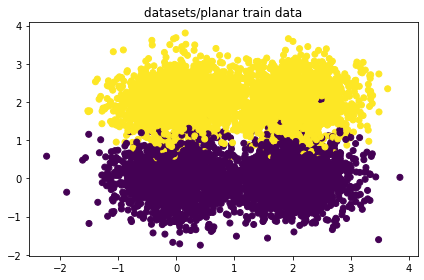

Dataset datasets/planar_train.csv loaded


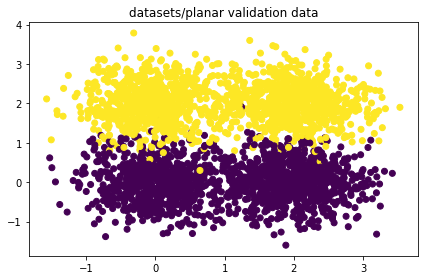

Dataset datasets/planar_validation.csv loaded
Total samples 10000 - Train (70.0%) - Validation (30.0%)


In [2]:
name, epochs = 'datasets/planar', 10

n_classes = 2
colors = ['r','b','g','y']

# We read the dataset and create an iterable.
class my_points(data.Dataset):
    def __init__(self, name, type, show_data=False, data_norm=True):
        # Read data
        pd_data = pd.read_csv(name+'_'+type+'.csv').values  # Read data file.
        self.data = pd_data[:, 0:2]  # 1st and 2nd columns --> x,y
        self.target = pd_data[:, 2:]  # 3nd column --> label

        # Show data
        if show_data:
            plt.scatter(self.data[:, 0], self.data[:, 1], c=self.target.reshape(-1))
            plt.title( name + ' ' + type +' data')
            plt.tight_layout()
            plt.show()
            #plt.show(block=False)
            #plt.pause(2.0)
            #plt.close()

        # Data normalization
        if data_norm:
            self.data -= np.mean(self.data, axis=0)
            self.data /= np.std(self.data, axis=0)

        self.n_samples = self.data.shape[0]

        print('Dataset {:s} loaded'.format(name+'_'+type+'.csv'))

    def __len__(self):  # Length of the dataset.
        return self.n_samples

    def __getitem__(self, index):  # Function that returns one point and one label.
        return torch.Tensor(self.data[index]), torch.Tensor(self.target[index])

# # We create the dataloader.
my_data = my_points(name, 'train', show_data=True)
train_samples = my_data.__len__()
my_data_validation = my_points(name, 'validation', show_data=True)
validation_samples = my_data_validation.__len__()
total_samples = train_samples + validation_samples
print('Total samples {:d} - Train ({:.1f}%) - Validation ({:.1f}%)'.format(total_samples, train_samples*100/total_samples, validation_samples*100/total_samples))

batch_size = 200
my_loader = data.DataLoader(my_data, batch_size=batch_size, num_workers=0)
my_loader_validation = data.DataLoader(my_data_validation, batch_size=len(my_data_validation), num_workers=0)
my_loader_train = data.DataLoader(my_data, batch_size=len(my_data), num_workers=0)


- A perceptron model is created:

In [3]:
# Define a class for the model
class my_model(nn.Module):
    def __init__(self, n_in=2, n_out=4):
        super(my_model, self).__init__()
        self.n_in = n_in
        self.n_out = n_out

        self.linearlinear = nn.Sequential(
            nn.Linear(self.n_in, self.n_out, bias=True), # planar -> 1 Perceptron
            nn.LogSoftmax(dim=1) # Log de las probabilidades
        )

    def forward(self, x):
        x = self.linearlinear(x)
        return x

# A model of the my_model class is instantiated.
model = my_model(n_out=n_classes)
print(model.linearlinear)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): LogSoftmax(dim=1)
)


In [4]:
def get_accuracy(my_model, my_loader):
    ''' Function for returning accuracy of a model for a mnist loader data.
    '''
    for data, target in my_loader:
        pred = my_model(data)
        pred = pred.exp().detach()  # exp of the log prob = probability.
        _, index = torch.max(pred, 1)  # index of the class with maximum probability.
        y_class = index.detach().numpy().reshape(-1, 1)
        y_hat = target.data.numpy()
        accuracy = np.sum(y_class == y_hat) / len(index)
    return(accuracy)

- The model is trained, that is, the model parameters are estimated:

In [5]:
# Defining the loss function
criterium = nn.NLLLoss()

# Defining the Adam optimizer with learning rate 0.1
learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # , weight_decay=1e-4  # and L2 regularization with weight 1e-4

# Supervised training
time0 = time()
best_validation_accuracy = 0.
max_iter = my_loader.__len__()*epochs
cost = np.zeros((max_iter, 1))
ucost = np.zeros((max_iter, 1))
acc = []
acc.append([get_accuracy(model, my_loader_train), get_accuracy(model, my_loader_validation)])
weight_ratios = np.zeros((max_iter, 1))
i, c_ant, beta = 0, 0, 0.9
for e in range(epochs):
    running_loss = 0
    for k, (data, target) in enumerate(my_loader):
        # Definition of inputs as variables for the net.
        # requires_grad is set False because we do not need to compute the
        # derivative of the inputs.
        data = Variable(data, requires_grad=False)
        target = Variable(target.long(), requires_grad=False)

        # Set gradient to 0.
        optimizer.zero_grad()
        # Feed forward.
        pred = model(data)
        # Loss calculation.
        loss = criterium(pred, target.view(-1))
        # Gradient calculation.
        weights = model.linearlinear[0].weight.data.numpy().ravel()
        loss.backward()
        grads_lr = model.linearlinear[0].weight.grad.numpy().ravel() * learning_rate
        weight_ratios[i] = np.linalg.norm(grads_lr) / np.linalg.norm(weights)

        # Plot loss y su media movil
        # cost[i] = loss.detach().numpy()
        cost[i] = loss.item()
        c_act = (1-beta)*cost[i] + beta * c_ant
        ucost[i]= c_act / (1-beta**(i+1))
        c_ant = c_act
        i+=1

        # # Print loss every 10 iterations.
        # if k % 10 == 0:
        #     print('Loss {:.4f} at iter {:d}'.format(loss.item(), i))

        # Model weight modification based on the optimizer.
        optimizer.step()

        running_loss += loss.item()
    else:
        # for k, (data_train, target_train) in enumerate(my_loader_train):
        #     pred_train = model(data_train)
        #     pred_train = pred_train.exp().detach()  # exp of the log prob = probability.
        #     _, index_train = torch.max(pred_train, 1)  # index of the class with maximum probability.
        #     y_class = index_train.detach().numpy().reshape(-1, 1)
        #     y_hat = target_train.data.numpy()
        #     train_accuracy = np.sum(y_class == y_hat) / len(index_train)
        train_accuracy = get_accuracy(model, my_loader_train)

        # for k, (data_validation, target_validation) in enumerate(my_loader_validation):
        #     pred_validation = model(data_validation)
        #     pred_validation = pred_validation.exp().detach()  # exp of the log prob = probability.
        #     _, index_validation = torch.max(pred_validation, 1)  # index of the class with maximum probability.
        #     y_class = index_validation.detach().numpy().reshape(-1, 1)
        #     y_hat = target_validation.data.numpy()
        #     validation_accuracy = np.sum(y_class == y_hat) / len(index_validation)
        validation_accuracy = get_accuracy(model, my_loader_validation)
        acc.append([train_accuracy, validation_accuracy])

        best = ' '
        if (validation_accuracy >= best_validation_accuracy):
            best = '*'
            loss_bestmodel = running_loss / len(my_loader)
            iter_bestmodel = i
            torch.save(model, name + '_model.pth')
            best_validation_accuracy = validation_accuracy

        print('Epoch {:d} - Training loss: {:.4f} - Validation accuracy: {:.4f} at iter {:d} {:s}'.format(e, running_loss / len(my_loader), validation_accuracy, i, best))

print("\nTraining Time (in seconds) =", time() - time0)


Epoch 0 - Training loss: 0.1756 - Validation accuracy: 0.9750 at iter 35 *
Epoch 1 - Training loss: 0.0720 - Validation accuracy: 0.9727 at iter 70  
Epoch 2 - Training loss: 0.0647 - Validation accuracy: 0.9723 at iter 105  
Epoch 3 - Training loss: 0.0618 - Validation accuracy: 0.9723 at iter 140  
Epoch 4 - Training loss: 0.0602 - Validation accuracy: 0.9723 at iter 175  
Epoch 5 - Training loss: 0.0594 - Validation accuracy: 0.9723 at iter 210  
Epoch 6 - Training loss: 0.0589 - Validation accuracy: 0.9720 at iter 245  
Epoch 7 - Training loss: 0.0586 - Validation accuracy: 0.9720 at iter 280  
Epoch 8 - Training loss: 0.0584 - Validation accuracy: 0.9720 at iter 315  
Epoch 9 - Training loss: 0.0583 - Validation accuracy: 0.9723 at iter 350  

Training Time (in seconds) = 6.135937452316284


- The evolution of the weight ratios, the loss function and the precision are shown:

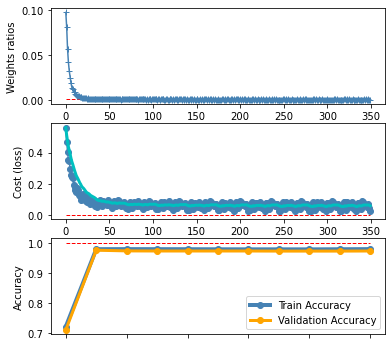

In [6]:
# Now, we plot the optimization results.
fig, ax = plt.subplots(3, 1, figsize=(6,6))
ax[0].plot(range(max_iter), np.ones(max_iter)*0.001,'r', linewidth=1, ls='--')
ax[0].plot(range(max_iter), weight_ratios, color='steelblue', marker='+')
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Weights ratios")
# Plot the loss C.
ax[1].plot(range(max_iter), np.zeros(max_iter),'r', linewidth=1, ls='--')
ax[1].plot(range(max_iter), cost, color='steelblue', marker='o')
ax[1].plot(range(max_iter), ucost,'c-', linewidth=3)
ax[1].set_xlabel("Iterations")
ax[1].set_ylabel("Cost (loss)")
# Plot the accuracies
acc_train = np.array(acc)[:,0]
acc_validation = np.array(acc)[:,1]
ax[2].plot(range(len(acc_train)), np.ones(len(acc_train)),'r', linewidth=1, ls='--')
ax[2].plot(acc_train, color='steelblue', marker='o', linewidth=4.0, label='Train Accuracy')
ax[2].plot(acc_validation, color='orange', marker='o', linewidth=3.0, label='Validation Accuracy')
ax[2].set_xticklabels([])
ax[2].set_ylabel("Accuracy")
ax[2].legend()
plt.show(block=True)


- The results are displayed:

Final ---> Loss 0.1756 - Accuracy 0.9750 at iter 35


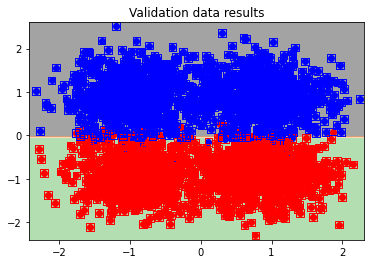

In [7]:

# Plot the predictions with the best model.
# Circles indicate the ground truth and the squares are the predictions.
# Ground truth y Predictions.

best_model = torch.load(name+'_model.pth')
best_model.eval()
for data_validation, target_validation in my_loader_validation:
    points = data_validation.numpy()

    # Show boundaries
    x_min, x_max = points[:, 0].min()-0.1, points[:, 0].max()+0.1
    y_min, y_max = points[:, 1].min()-0.1, points[:, 1].max()+0.1
    spacing = min(x_max - x_min, y_max - y_min) / 100
    XX, YY = np.meshgrid(np.arange(x_min, x_max, spacing),np.arange(y_min, y_max, spacing))
    data = np.hstack((XX.ravel().reshape(-1,1),YY.ravel().reshape(-1,1)))
    data_t = torch.FloatTensor(data)
    db_prob = best_model(data_t)
    pred_ret = db_prob.exp().detach()     # exp of the log prob = probability.
    _, index_ret = torch.max(pred_ret,1)   # index of the class with maximum probability.
    clf = index_ret.detach().numpy()
    Z = clf.reshape(XX.shape)
    plt.contourf(XX, YY, Z, cmap=plt.cm.Accent, alpha=0.6)

    # Validation predictions.
    pred_validation = best_model(data_validation)
    pred_validation = pred_validation.exp().detach()  # exp of the log prob = probability.
    _, index_validation = torch.max(pred_validation, 1)  # index of the class with maximum probability.
    y_class = index_validation.detach().numpy().reshape(-1, 1)
    y_hat = target_validation.data.numpy()
    validation_accuracy = np.sum(y_class == y_hat) / len(index_validation)

    print('Final ---> Loss {:.4f} - Accuracy {:.4f} at iter {:d}'.format(loss_bestmodel, validation_accuracy, iter_bestmodel))

    # Ground truth.
    for k in range(n_classes):
        select = y_hat[:,0]==k
        p = points[select,:]
        plt.scatter(p[:,0],p[:,1],facecolors=colors[k])

    for k in range(n_classes):
        select = y_class[:,0]==k
        p = points[select,:]
        plt.scatter(p[:,0],p[:,1],s=60,marker='s',edgecolors=colors[k],facecolors='none')

    plt.title('Validation data results')
    plt.show()

# Task 1 (design and analysis of the crossover dataset)

# Task 2 (design and analysis of the circles dataset)

# Task 3 (design and analysis of the moons dataset)

# Task 4 (design and analysis of the spirals dataset)